In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import meerkat as mk
from domino import DominoSlicer
from classifer import *
from bootstrap_utilis import *
from sklearn.metrics import accuracy_score


Class Label Y: Finding (0: Normal/ 1: Abnormal)


Error Attribute (Position)

In [201]:
# V12 & V13
# This is a sample run for "Finding vs. Postition". 
# The noise strength is 0.3.
# Position 1 (frontal) and Position 2 (lateral) 
# We would like to have Classifier that underperforms when the sample is frontal 


### Data Preparation

In [193]:
label_1 = 'Cardiomegaly'
label_2 = 'Position'

attribute = False  # If True, the classifier will be biased towards the attribute
print("=================== Bootstrap Experiment ==========")
print(f"This the experiment for {label_1} and {label_2} labels")
test_df = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/data/test_df_with_embeddings_cardio_position.parquet")
test_df = test_df[test_df["Cardiomegaly"].isin([1, 0])].reset_index(drop=True)
print("Loading test and train DataFrames...")
train_df = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/data/train_df_cardio_position.parquet")
train_df = train_df[train_df["Cardiomegaly"].isin([1, 0])].reset_index(drop=True)
print("Create the embeddings for the test DataFrame...")
test_df["combined_embedding"] = get_combined_embedding(test_df, 'image_embedding', 'report_embedding', n_components=512)
test_df["combined_emebdding_v2"] = get_combined_embedding(test_df, 'image_embedding', 'report_embedding', 'metadata_embedding', 512)
test_df["combined_embedding_v3"] = get_combined_embedding(test_df, 'report_embedding', 'metadata_embedding', n_components=512)
test_df["combined_embedding_v4"] = get_combined_embedding(test_df, 'image_embedding', 'metadata_embedding')
root_folder = "/vol/bitbucket/yl28218/thesis/physionet.org/files/mimic-cxr-jpg/2.1.0/files"
selected_columns = [label_2, 'predicted', 'true', 'id', 'path', 'report_text', 'image_embedding', 'report_embedding', 'metadata_embedding', "Rows", "Columns", "metadata_description", "combined_embedding", "combined_emebdding_v2", "combined_embedding_v3", "combined_embedding_v4"]
checkpointpath = None
token_results = {"image_only": [], "image_text": [], "image_text_meta": [], "text": [], "meta": [], "report_metadata": [], "image_metadata": []}


    
seed =43
k = 10
max_features = 1000

threshold = 0.1

=================== Bootstrap Experiment ==========
This the experiment for Cardiomegaly and Position labels
Loading test and train DataFrames...
Create the embeddings for the test DataFrame...


In [194]:
label_1_values = 1

In [195]:
seed =42

In [196]:
def get_df_with_rare_attr(df, label_1, label_2, size=1000, strength=0.05, 
                          label1_value=1, label2_value=1, seed=42):
   

    np.random.seed(seed)

 
    per_class_size = size // 2


    rare_size = int(size * strength)


    df_rare = df[(df[label_1] == label1_value) & (df[label_2] == label2_value)] \
                .sample(n=rare_size, random_state=seed)


    df_not_rare_target = df[(df[label_1] == label1_value) & (df[label_2] != label2_value)] \
                .sample(n=per_class_size - rare_size, random_state=seed)


    df_non_target = df[df[label_1] != label1_value] \
                .sample(n=per_class_size, random_state=seed)


    df_combined = pd.concat([df_rare, df_not_rare_target, df_non_target]).reset_index(drop=True)
    df_combined = df_combined.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_combined


### Classifier Training 

In [5]:
train = get_df_with_rare_attr(train_df, label_1, label_2, size=1000, strength=0.01, label1_value=1, label2_value=0, seed=seed)
train.groupby(['Position', 'Cardiomegaly']).size().unstack(fill_value=0)

Cardiomegaly,0.0,1.0
Position,,
0,196,10
1,304,490


In [167]:
if attribute:
        print(f"In this experiment, with the attribute {label_2}, the model would underperform systembatically.")
else:
        print(f"In this experiment, with the attribute {label_2}, the model would outperform systembatically.")

while True:
    np.random.seed(seed)

    rare_strength = 0.02
    print(f"rare_strength: {rare_strength}, seed: {seed}")
    if attribute:
        label_2_value = 1
    else:
        label_2_value = 0
    train = get_df_with_rare_attr(train_df, label_1, label_2, size=1000, strength=rare_strength, label1_value=1, label2_value=0, seed=seed)
    test = test_df.sample(n=300, random_state=seed).reset_index(drop=True)
    #val = test[test['Support Devices'] == 0].copy()
    # Ensure the validation set has no support devices, so the classifier is baised on the absence of support devices
    if attribute:
        val = test[test[label_2] != 1].copy()
    else:
        val = test[test[label_2] == 1].copy()

    # Train the classifier
    print("Training the classifier...")

    best_acc, best_model, strength = train_model(train, val, root_folder, label_1, label_2, checkpointpath, epochs=10)
    if best_model is not None:
        test_results = evaluate_best_model(best_model, test, root_folder, label_1)

        if len(test_results) > 0:
            avg_test_acc = accuracy_score(test_results["true"], test_results["predicted"])
            print(f"Average Test Accuracy: {avg_test_acc:.4f}")
            test_results_1 = test_results[test_results[label_1] == 1].copy()

            if label_2 in test_results.columns:
                support_mask = test_results_1[label_2] == 1
                if support_mask.sum() > 0:
                    support_acc = accuracy_score(test_results_1[support_mask]["true"], test_results_1[support_mask]["predicted"])
                    print(f" {label_2} X-ray Accuracy: {support_acc:.4f}")

                no_support_mask = test_results_1[label_2] != 1
                if no_support_mask.sum() > 0:
                    no_support_acc = accuracy_score(test_results_1[no_support_mask]["true"], test_results_1[no_support_mask]["predicted"])
                    print(f"No {label_2} X-ray Accuracy: {no_support_acc:.4f}")
        else:
            print("No test results to analyze.")
    else:
        print("No valid model trained.")

    print("Classifier training completed.")
    if attribute:
        difference = no_support_acc - support_acc
    else:
        difference = support_acc - no_support_acc

    if  difference >= threshold:
        print(f"{label_2} X-ray Accuracy  is significantly lower than no {label_2} X-ray Accuracy by {no_support_acc - support_acc:.4f}, proceeding with analysis.")
        # Proceed with the analysis
        break 

    else:
        print("The training was unsuccessful, skipping this iteration.")
        seed += 1
        continue
    
        

In this experiment, with the attribute Position, the model would outperform systembatically.
rare_strength: 0.02, seed: 43
Training the classifier...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for train set...


100%|██████████| 1000/1000 [00:21<00:00, 46.46it/s]


Original train samples: 1000
Valid train samples: 876
Missing train samples: 124
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for validation set...


100%|██████████| 268/268 [00:04<00:00, 57.31it/s]


Original validation samples: 268
Valid validation samples: 268
Missing validation samples: 0
========== Correlation Analysis =========
Correlation strength between Cardiomegaly and Position in clean train set): 0.417


Epoch 1/10: 100%|██████████| 110/110 [03:43<00:00,  2.03s/it]


Epoch 1 done. Avg Loss = 0.6363


Validating: 100%|██████████| 34/34 [00:48<00:00,  1.43s/it]


Val Accuracy: 0.4478


Epoch 2/10: 100%|██████████| 110/110 [01:53<00:00,  1.03s/it]


Epoch 2 done. Avg Loss = 0.5712


Validating: 100%|██████████| 34/34 [00:24<00:00,  1.41it/s]


Val Accuracy: 0.4963


Epoch 3/10: 100%|██████████| 110/110 [01:07<00:00,  1.64it/s]


Epoch 3 done. Avg Loss = 0.5248


Validating: 100%|██████████| 34/34 [00:24<00:00,  1.41it/s]


Val Accuracy: 0.4813


Epoch 4/10: 100%|██████████| 110/110 [01:06<00:00,  1.66it/s]


Epoch 4 done. Avg Loss = 0.4961


Validating: 100%|██████████| 34/34 [00:22<00:00,  1.53it/s]


Val Accuracy: 0.5933


Epoch 5/10: 100%|██████████| 110/110 [01:05<00:00,  1.67it/s]


Epoch 5 done. Avg Loss = 0.4268


Validating: 100%|██████████| 34/34 [00:22<00:00,  1.54it/s]


Val Accuracy: 0.5634


Epoch 6/10: 100%|██████████| 110/110 [01:12<00:00,  1.51it/s]


Epoch 6 done. Avg Loss = 0.4119


Validating: 100%|██████████| 34/34 [00:23<00:00,  1.47it/s]


Val Accuracy: 0.5597


Epoch 7/10: 100%|██████████| 110/110 [01:25<00:00,  1.28it/s]


Epoch 7 done. Avg Loss = 0.3826


Validating: 100%|██████████| 34/34 [00:21<00:00,  1.55it/s]


Val Accuracy: 0.5672
Early stopping triggered.
Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:00<00:00, 310.15it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:22<00:00,  1.72it/s]


Test Accuracy: 0.6033
Average Test Accuracy: 0.6033
 Position X-ray Accuracy: 0.7159
No Position X-ray Accuracy: 0.5000
Classifier training completed.
Position X-ray Accuracy  is significantly lower than no Position X-ray Accuracy by -0.2159, proceeding with analysis.


In [197]:
# label_2 = 0 and label_1 = 1
test_underperforming = test_df[(test_df[label_2] == 0) & (test_df[label_1] == 1)].copy()
test_rest = test_df[(test_df[label_2] != 0) | (test_df[label_1] != 1)].copy()
test_1 = test_underperforming.sample(n=60, random_state=seed).reset_index(drop=True)
print(f"Number of test samples with {label_2} = 0 and {label_1} = 1: {len(test_1)}")
test_2 = test_rest.sample(n=270, random_state=seed).reset_index(drop=True)
print(f"Number of test samples with {label_2} != 0 or {label_1} != 1: {len(test_2)}")
test = pd.concat([test_1, test_2], ignore_index=True)   
#shuffle the test set
test = test.sample(frac=1, random_state=seed).reset_index(drop=True)

Number of test samples with Position = 0 and Cardiomegaly = 1: 60
Number of test samples with Position != 0 or Cardiomegaly != 1: 270


In [198]:
test_results = evaluate_best_model(best_model, test, root_folder, label_1)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 330/330 [00:07<00:00, 46.85it/s]


Original test samples: 330
Valid test samples: 330
Missing test samples: 0


Testing: 100%|██████████| 42/42 [00:24<00:00,  1.75it/s]

Test Accuracy: 0.5667


In [199]:
#calculate the accuracy for the test set
test_results_0 = test_results[test_results[label_1] == 1].copy()
test_results_0_lateral = test_results_0[test_results_0[label_2] == 0].copy()
test_results_0_frontal = test_results_0[test_results_0[label_2] == 1].copy()
# accuracy for the test set
test_results_0_lateral_acc = accuracy_score(test_results_0_lateral["true"], test_results_0_lateral["predicted"])
test_results_0_frontal_acc = accuracy_score(test_results_0_frontal["true"], test_results_0_frontal["predicted"])
print(f"Test set accuracy for {label_2} = 0 (lateral): {test_results_0_lateral_acc:.4f}")
print(f"Test set accuracy for {label_2} = 1 (frontal): {test_results_0_frontal_acc:.4f}")


Test set accuracy for Position = 0 (lateral): 0.4167
Test set accuracy for Position = 1 (frontal): 0.6818


In [200]:
test_results.groupby([label_2, label_1]).size().unstack(fill_value=0)

Cardiomegaly,0.0,1.0
Position,,
0,20,60
1,162,88


### Domino

In [201]:
def analyze_error_slice_tokens(slice_df, test_df, k=20, max_features=1000, seed=42):
    most_common_class = slice_df['true'].value_counts().idxmax()
    correct_df = test_df[(test_df['true'] == most_common_class) & (test_df['predicted'] == most_common_class)]

    error_texts = (slice_df['report_text'].fillna('') + ' ' + slice_df['metadata_description'].fillna('')).tolist()
    normal_texts = (correct_df['report_text'].fillna('') + ' ' + correct_df['metadata_description'].fillna('')).tolist()
    all_texts = normal_texts + error_texts
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 4),
        stop_words="english",
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    split_index = len(normal_texts)
    tfidf_array = tfidf_matrix.toarray()
    normal_avg = np.mean(tfidf_array[:split_index], axis=0)
    error_avg = np.mean(tfidf_array[split_index:], axis=0)
    #diff_scores = error_avg - normal_avg
    diff_scores = error_avg - normal_avg
    analyzer = vectorizer.build_analyzer()
    error_tokens = sum((analyzer(t) for t in error_texts), [])
    normal_tokens = sum((analyzer(t) for t in normal_texts), [])
    error_counts = Counter(error_tokens)
    normal_counts = Counter(normal_tokens)
    result_df = pd.DataFrame({
        'token': feature_names,
        'diff_score': diff_scores,
        'error_count': [error_counts[token] for token in feature_names],
        'normal_count': [normal_counts[token] for token in feature_names]
    })
    return result_df.sort_values(by='diff_score', ascending=False)

In [202]:
def domino_wrapper(mk_df, embeddings_col, targets_col, slice_name, pred_probs_col, seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    domino = DominoSlicer(
        y_log_likelihood_weight=10,
        y_hat_log_likelihood_weight=10,
        n_mixture_components=20,
        n_slices=5,
        random_state=seed,
        init_params="kmeans"
    )
    domino.fit(data=mk_df, embeddings=embeddings_col, targets=targets_col, pred_probs=pred_probs_col)
    mk_df[slice_name] = domino.predict_proba(data=mk_df, embeddings=embeddings_col, targets=targets_col, pred_probs=pred_probs_col)
    return mk_df

In [203]:
mk_df = create_meerkat_datapanel(test_results, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')




slice_1, precision_k_1 = best_precision_slice('slice_image_only', mk_df, label_2, label_1_values, k, attribute)
slice_2, precision_k_2 = best_precision_slice('slice_image_text', mk_df, label_2, label_1_values, k, attribute)
slice_3, precision_k_3 = best_precision_slice('slice_image_text_meta', mk_df, label_2, label_1_values, k, attribute)
slice_4, precision_k_4 = best_precision_slice('slice_report_text', mk_df, label_2, label_1_values, k, attribute)
slice_5, precision_k_5 = best_precision_slice('slice_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_6, precision_k_6 = best_precision_slice('slice_report_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_7, precision_k_7 = best_precision_slice('slice_image_metadata', mk_df, label_2, label_1_values, k, attribute)


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")


tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

 19%|█▉        | 19/100 [00:00<00:00, 511.94it/s]


Precision@10 for Image Only Slice: 0.4000
Precision@10 for Image + Text Slice: 0.0000
Precision@10 for Image + Text + Metadata Slice: 1.0000
Precision@10 for Report Text Slice: 0.7000
Precision@10 for Metadata Slice: 1.0000
Precision@10 for Report + Metadata Slice: 1.0000
Precision@10 for Image + Metadata Slice: 1.0000


In [204]:
# the samples with wrong predictions
test_results_incorrect = test_results[test_results['true'] != test_results['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect['Position'] = test_results_incorrect['Position'].fillna(0)
support_devices_count = test_results_incorrect['Position'].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = 1- (support_devices_count / total_count if total_count > 0 else 0)
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.2797


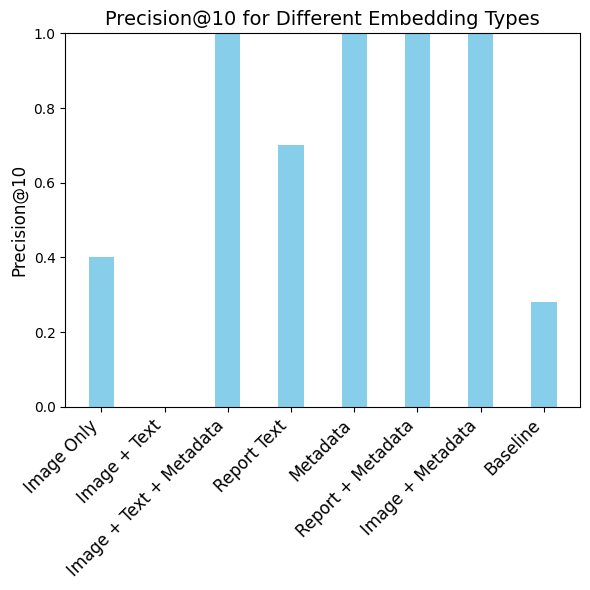

In [205]:
from matplotlib import pyplot as plt


k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="skyblue",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(f"Precision@{k} for Different Embedding Types", fontsize=14)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()


In [206]:
c = analyze_error_slice_tokens(test_results, test_results, k, max_features)
c.head(10)


,token,diff_score,error_count,normal_count
94,cardiomegaly,0.018159,78,2
704,pulmonary,0.014001,189,33
517,mild,0.013805,106,13
243,edema,0.013531,153,24
705,pulmonary edema,0.012149,119,18
688,previous,0.011035,74,10
525,moderate,0.009874,98,17
526,moderate cardiomegaly,0.009501,29,0
254,effusions,0.008784,97,16
500,lung volumes,0.008303,61,9


In [207]:
tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

In [208]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
921,trace,0.072866,3,4
453,low,0.066067,4,14
415,lateral,0.064612,6,45
979,volumes,0.058434,4,17
942,underwent chest radiography november,0.055048,2,3


In [209]:
tokens_slice_2.head()

,token,diff_score,error_count,normal_count
805,right,0.035015,85,151
493,lower,0.034325,28,27
496,lower lung,0.026152,11,3
63,base,0.023546,13,9
497,lung,0.023197,39,62


In [210]:
tokens_slice_3.head()

,token,diff_score,error_count,normal_count
429,lateral,0.068435,36,45
431,lateral view,0.046789,24,26
195,cough,0.045476,7,0
436,lateral view patient upright,0.045226,12,8
434,lateral view patient,0.044812,20,25


In [211]:
tokens_slice_4.head()

,token,diff_score,error_count,normal_count
565,pa lat,0.055817,13,12
438,lat,0.055817,13,12
132,chest pa lat,0.055817,13,12
131,chest pa,0.055817,13,12
441,lat indication year old,0.051527,12,11


In [212]:
tokens_slice_5.head()

,token,diff_score,error_count,normal_count
593,performed lateral view,0.045978,10,25
294,examination performed lateral view,0.045978,10,25
592,performed lateral,0.045978,10,25
594,performed lateral view patient,0.045978,10,25
362,hours examination performed lateral,0.045978,10,25


In [213]:
tokens_slice_6.head()

,token,diff_score,error_count,normal_count
449,lateral,0.069341,47,45
572,pa,0.051279,29,24
453,lateral view,0.043271,28,26
133,chest pa lat,0.042063,18,12
573,pa lat,0.042063,18,12


In [214]:
tokens_slice_7.head()

,token,diff_score,error_count,normal_count
440,lateral,0.048418,19,45
443,lateral view patient,0.045768,15,25
291,examination performed lateral,0.045768,15,25
594,performed lateral view patient,0.045768,15,25
370,hours examination performed lateral,0.045768,15,25


In [292]:
# label_2 = 0 and label_1 = 1
seed =43
test_underperforming = test_df[(test_df[label_2] == 0) & (test_df[label_1] == 1)].copy()
test_rest = test_df[(test_df[label_2] != 0) | (test_df[label_1] != 1)].copy()
test_1 = test_underperforming.sample(n=30, random_state=seed).reset_index(drop=True)
print(f"Number of test samples with {label_2} = 0 and {label_1} = 1: {len(test_1)}")
test_2 = test_rest.sample(n=270, random_state=seed).reset_index(drop=True)
print(f"Number of test samples with {label_2} != 0 or {label_1} != 1: {len(test_2)}")
test = pd.concat([test_1, test_2], ignore_index=True)   
#shuffle the test set
test = test.sample(frac=1, random_state=seed).reset_index(drop=True)

Number of test samples with Position = 0 and Cardiomegaly = 1: 30
Number of test samples with Position != 0 or Cardiomegaly != 1: 270


In [293]:
test.groupby(['Position', 'Cardiomegaly']).size().unstack(fill_value=0)

Cardiomegaly,0.0,1.0
Position,,
0,29,30
1,158,83


In [294]:
test_results_2 = evaluate_best_model(best_model, test, root_folder, label_1)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:05<00:00, 52.48it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]


Test Accuracy: 0.6133


In [295]:
#calculate the accuracy for the test set
test_results_0 = test_results_2[test_results_2[label_1] == 1].copy()
test_results_0_lateral = test_results_0[test_results_0[label_2] == 0].copy()
test_results_0_frontal = test_results_0[test_results_0[label_2] == 1].copy()
# accuracy for the test set
test_results_0_lateral_acc = accuracy_score(test_results_0_lateral["true"], test_results_0_lateral["predicted"])
test_results_0_frontal_acc = accuracy_score(test_results_0_frontal["true"], test_results_0_frontal["predicted"])
print(f"Test set accuracy for {label_2} = 0 (lateral): {test_results_0_lateral_acc:.4f}")
print(f"Test set accuracy for {label_2} = 1 (frontal): {test_results_0_frontal_acc:.4f}")

Test set accuracy for Position = 0 (lateral): 0.6000
Test set accuracy for Position = 1 (frontal): 0.7229


In [296]:
mk_df = create_meerkat_datapanel(test_results_2, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

 17%|█▋        | 17/100 [00:00<00:00, 804.41it/s]


In [297]:
slice_1, precision_k_1 = best_precision_slice('slice_image_only', mk_df, label_2, label_1_values, k, attribute)
slice_2, precision_k_2 = best_precision_slice('slice_image_text', mk_df, label_2, label_1_values, k, attribute)
slice_3, precision_k_3 = best_precision_slice('slice_image_text_meta', mk_df, label_2, label_1_values, k, attribute)
slice_4, precision_k_4 = best_precision_slice('slice_report_text', mk_df, label_2, label_1_values, k, attribute)
slice_5, precision_k_5 = best_precision_slice('slice_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_6, precision_k_6 = best_precision_slice('slice_report_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_7, precision_k_7 = best_precision_slice('slice_image_metadata', mk_df, label_2, label_1_values, k, attribute)


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")


tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

Precision@10 for Image Only Slice: 0.2000
Precision@10 for Image + Text Slice: 0.0000
Precision@10 for Image + Text + Metadata Slice: 0.0000
Precision@10 for Report Text Slice: 0.2000
Precision@10 for Metadata Slice: 0.0000
Precision@10 for Report + Metadata Slice: 0.0000
Precision@10 for Image + Metadata Slice: 0.5000


In [298]:
# the samples with wrong predictions
test_results_incorrect = test_results_2[test_results_2['true'] != test_results_2['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect['Position'] = test_results_incorrect['Position'].fillna(0)
support_devices_count = test_results_incorrect['Position'].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = 1- (support_devices_count / total_count if total_count > 0 else 0)
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.1983


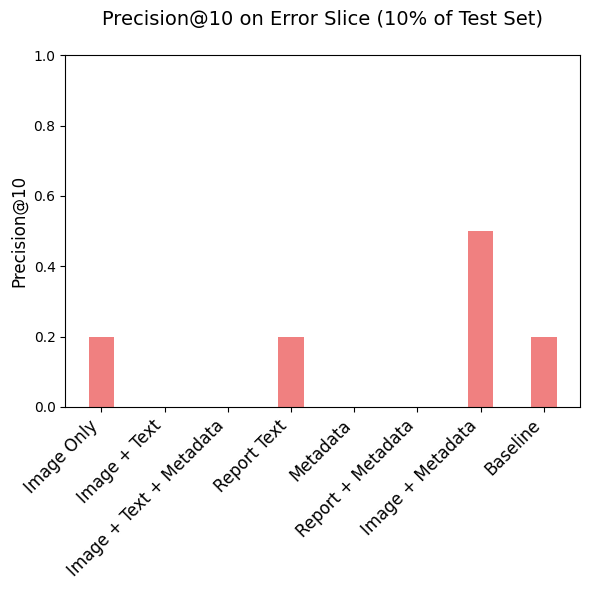

In [299]:



k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="lightcoral",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (10% of Test Set)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

In [272]:
seed =41
test_underperforming = test_df[(test_df[label_2] == 0) & (test_df[label_1] == 1)].copy()
test_rest = test_df[(test_df[label_2] != 0) | (test_df[label_1] != 1        
)].copy()
test_1 = test_underperforming.sample(n=15, random_state=seed).reset_index(drop=True)
print(f"Number of test samples with {label_2} = 0 and {label_1} = 1: {len(test_1)}")
test_2 = test_rest.sample(n=285, random_state=seed).reset_index(drop=True)
print(f"Number of test samples with {label_2} != 0 or {label_1} != 1: {len(test_2)}")
test = pd.concat([test_1, test_2], ignore_index=True)   
#shuffle the test set
test = test.sample(frac=1, random_state=seed).reset_index(drop=True)

Number of test samples with Position = 0 and Cardiomegaly = 1: 15
Number of test samples with Position != 0 or Cardiomegaly != 1: 285


In [273]:
test_results_3 = evaluate_best_model(best_model, test, root_folder, label_1)
#calculate the accuracy for the test set

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:08<00:00, 33.48it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:50<00:00,  1.32s/it]

Test Accuracy: 0.5367


In [270]:
mk_df = create_meerkat_datapanel(test_results_3, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

 20%|██        | 20/100 [00:00<00:00, 755.12it/s]


In [275]:
slice_1, precision_k_1 = best_precision_slice('slice_image_only', mk_df, label_2, label_1_values, k, attribute)
slice_2, precision_k_2 = best_precision_slice('slice_image_text', mk_df, label_2, label_1_values, k, attribute)
slice_3, precision_k_3 = best_precision_slice('slice_image_text_meta', mk_df, label_2, label_1_values, k, attribute)
slice_4, precision_k_4 = best_precision_slice('slice_report_text', mk_df, label_2, label_1_values, k, attribute)
slice_5, precision_k_5 = best_precision_slice('slice_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_6, precision_k_6 = best_precision_slice('slice_report_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_7, precision_k_7 = best_precision_slice('slice_image_metadata', mk_df, label_2, label_1_values, k, attribute)


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")


tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

Precision@10 for Image Only Slice: 0.0000
Precision@10 for Image + Text Slice: 0.0000
Precision@10 for Image + Text + Metadata Slice: 0.0000
Precision@10 for Report Text Slice: 0.1000
Precision@10 for Metadata Slice: 0.0000
Precision@10 for Report + Metadata Slice: 0.0000
Precision@10 for Image + Metadata Slice: 0.0000


In [276]:
slice_1 = error_slice_producer(4, 'slice_image_only', mk_df, label_2)
slice_1.head(10)
precision_k_1 = compute_precision_k(slice_1, label_2, k, attribute)
print(f"Precision@{k} for Image Only Slice with Rare Attribute: {precision_k_1:.4f}")
slice_1.head(10)

Precision@10 for Image Only Slice with Rare Attribute: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
262,1,0,"FINAL REPORT\n PA AND LATERAL CHEST, ___.\n \n...",Patient underwent chest radiography in January...,1,1.0
151,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
142,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
71,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
256,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
296,1,0,WET READ: ___ ___ 10:24 PM\n Right chest tube...,Patient underwent bedside portable chest radio...,1,1.0
1,0,0,FINAL REPORT\n INDICATION: Edema.\n \n COMPAR...,Patient underwent bedside portable chest radio...,1,1.0
219,1,0,WET READ: ___ ___ ___ 2:38 PM\n \n Endotrach...,Patient underwent bedside portable chest radio...,1,1.0
189,1,0,FINAL REPORT\n HISTORY: Shortness of breath.\...,Patient underwent bedside portable chest radio...,1,1.0
165,1,0,"FINAL REPORT\n AP CHEST, 8:08 A.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0


In [277]:
slice_2 = error_slice_producer(1, 'slice_image_text', mk_df, label_2)
precision_k_2 = compute_precision_k(slice_2, label_2, k, attribute)
print(f"Precision@{k} for Image + Text Slice with Rare Attribute: {precision_k_2:.4f}")
slice_2.head(10)

Precision@10 for Image + Text Slice with Rare Attribute: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
4,1,0,FINAL REPORT\n INDICATION: ___-year-old femal...,Patient underwent chest radiography in October...,1,1.0
8,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
26,1,0,"FINAL REPORT\n AP CHEST, 3:57 A.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0
49,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
50,1,0,"FINAL REPORT\n AP CHEST, 5:43 A.M., ON ___\n \...",Patient underwent bedside portable chest radio...,1,1.0
71,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
141,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
142,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
152,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
232,1,0,"FINAL REPORT\n PORTABLE CHEST, ___\n \n COMPAR...",Patient underwent bedside portable chest radio...,1,1.0


In [278]:
slice_5 = error_slice_producer(3, 'slice_report_text', mk_df, label_2)
precision_k_4 = compute_precision_k(slice_5, label_2, k, attribute)
print(f"Precision@{k} for Metadata Slice with Rare Attribute: {precision_k_5:.4f}") 
slice_5.head(10)

Precision@10 for Metadata Slice with Rare Attribute: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
279,1,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,1.000000
232,1,0,"FINAL REPORT\n PORTABLE CHEST, ___\n \n COMPAR...",Patient underwent bedside portable chest radio...,1,1.000000
182,1,0,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent bedside portable chest radio...,1,1.000000
141,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.000000
50,1,0,"FINAL REPORT\n AP CHEST, 5:43 A.M., ON ___\n \...",Patient underwent bedside portable chest radio...,1,1.000000
256,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
71,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
1,0,0,FINAL REPORT\n INDICATION: Edema.\n \n COMPAR...,Patient underwent bedside portable chest radio...,1,1.000000
67,0,0,"FINAL REPORT\n AP CHEST, 9:00 A.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,0.999995
274,0,0,FINAL REPORT\n SINGLE FRONTAL VIEW OF THE CHES...,Patient underwent bedside portable chest radio...,1,0.999994


In [279]:
slice_6 = error_slice_producer(3, 'slice_report_metadata', mk_df, label_2)
precision_k_6 = compute_precision_k(slice_6, label_2, k, attribute)
print(f"Precision@{k} for Report + Metadata Slice with Rare Attribute: {precision_k_6:.4f}")
slice_6.head(10)

Precision@10 for Report + Metadata Slice with Rare Attribute: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
8,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
49,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
165,1,0,"FINAL REPORT\n AP CHEST, 8:08 A.M., ___\n \n H...",Patient underwent bedside portable chest radio...,1,1.0
142,1,0,"FINAL REPORT\n STUDY: AP chest, ___.\n \n CLI...",Patient underwent bedside portable chest radio...,1,1.0
250,1,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
195,1,0,FINAL REPORT\n PORTABLE AP CHEST FROM ___ AT 5...,Patient underwent bedside portable chest radio...,1,1.0
189,1,0,FINAL REPORT\n HISTORY: Shortness of breath.\...,Patient underwent bedside portable chest radio...,1,1.0
151,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
234,1,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
212,1,0,"FINAL REPORT\n AP CHEST, 4:20 A.M.\n \n HISTOR...",Patient underwent bedside portable chest radio...,1,1.0


In [280]:
slice_7 = error_slice_producer(0, 'slice_image_metadata', mk_df, label_2)
precision_k_7 = compute_precision_k(slice_7, label_2, k, attribute)
print(f"Precision@{k} for Image + Metadata Slice with Rare Attribute: {precision_k_7:.4f}")
slice_7.head(10)

Precision@10 for Image + Metadata Slice with Rare Attribute: 0.0000


,true,predicted,report_text,metadata_description,Position,slice_score
24,0,1,FINAL REPORT\n EXAMINATION: Chest radiograph....,Patient underwent bedside portable chest radio...,1,1.0
29,0,1,FINAL REPORT\n INDICATION: ___F with L IJ pla...,Patient underwent bedside portable chest radio...,1,1.0
56,0,1,FINAL REPORT\n INDICATION: Status post left i...,Patient underwent bedside portable chest radio...,1,1.0
58,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
72,0,1,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent bedside portable chest radio...,1,1.0
91,0,1,FINAL REPORT\n TYPE OF EXAMINATION: Chest AP ...,Patient underwent bedside portable chest radio...,1,1.0
73,0,1,WET READ: ___ ___ ___ 8:37 AM\n \n \n Compa...,Patient underwent bedside portable chest radio...,1,1.0
257,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
163,0,1,WET READ: ___ ___ 1:55 PM\n \n \n \n Left-...,Patient underwent bedside portable chest radio...,1,1.0
96,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [281]:
# the samples with wrong predictions
test_results_incorrect = test_results_3[test_results_3['true'] != test_results_3['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect['Position'] = test_results_incorrect['Position'].fillna(0)
support_devices_count = test_results_incorrect['Position'].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = 1- (support_devices_count / total_count if total_count > 0 else 0)
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.1151


In [288]:
tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

In [290]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
351,heart size normal,0.028613,9,0
862,size normal,0.028447,10,1
535,normal,0.028027,17,10
159,clear,0.027536,12,4
653,portable,0.025640,59,95


In [291]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
351,heart size normal,0.028613,9,0
862,size normal,0.028447,10,1
535,normal,0.028027,17,10
159,clear,0.027536,12,4
653,portable,0.025640,59,95


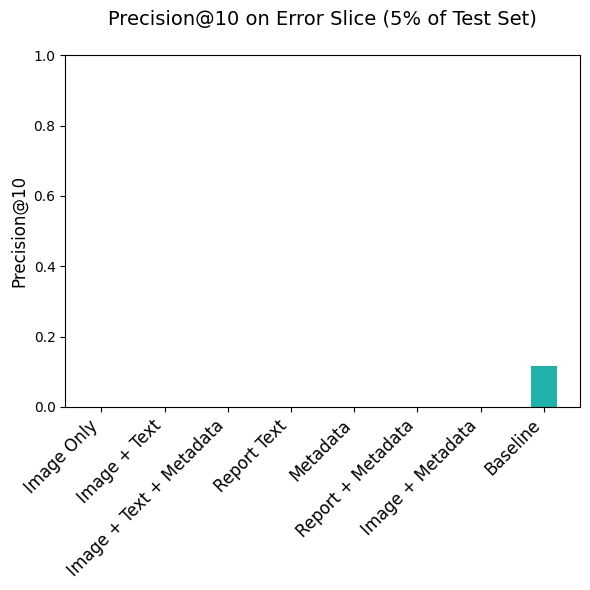

In [ ]:
k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="lightseagreen",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (5% of Test Set)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

In [259]:
#save the results to  parquet files
output_dir = "/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/results/exp3"
if not os.path.exists(output_dir):  
    os.makedirs(output_dir)
test_results_3.to_parquet(os.path.join(output_dir, "test_results_exp3.parquet"), index=False)


Deepseek